# CMIP6 - analysis of global warming

In this notebook, we show how to access CMIP6 data at the DKRZ filesystem using the Intake catalog and xarray. To lift the heavy datasets we will process in parallel with dask using the power of the mistral supercomputer. This notebook is loosely based on the [CMIP6 global temperature pangeo example](http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/global_mean_surface_temp.html).

import all neccessary modules here:

In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
from tqdm.autonotebook import tqdm
import intake
import intake_esm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

intake_esm.__version__

ModuleNotFoundError: No module named 'matplotlib'

## Data access

We use `dask.distributed` to parallelize file access and processing. This will speed up our computations...

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58966,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:58982,Total threads: 1
Dashboard: http://127.0.0.1:58987/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:58969,


If you click on the dashboard link, you will see the dask workers in action!

### Choose the catalog

We don't want to access single files or look for input data manually by browsing through some filesystem. Instead we use an [intake-esm](https://intake-esm.readthedocs.io/en/stable/) catalog that we can use to filter datasets by using actual dataset attributes (instead of looking for filenames). There are a number of data providers which offer intake catalogs for CMIP6 data (including DKRZ). The big advantage of this: If you want to reproduce/reuse somebodys work, you only need to choose an appropriate data provider you have access to. Here we show three urls corresponding to three data providers ([DKRZ data pool](https://www.dkrz.de/up/services/data-management/cmip-data-pool), [pangeo google cloud](https://pangeo-data.github.io/pangeo-cmip6-cloud/accessing_data.html), [ESGF AWS](https://registry.opendata.aws/cmip6/)):

In [3]:
import intake
%matplotlib
url = "/work/ik1017/Catalogs/mistral-cmip6.json"
gc_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
aws_url = "https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json"
%time cat = intake.open_esm_datastore(gc_url)
%time cat

Using matplotlib backend: <object object at 0x10be321d0>
CPU times: user 7.12 s, sys: 1.96 s, total: 9.08 s
Wall time: 48.7 s
CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs


,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514961
dcpp_init_year,60


In this example, we choose the google cloud url, so that this notebook can be run mostly on any computer with internet access.

The catalog is build around a pandas dataframe. We can also access it to explore the available data, e.g., 

In [4]:
cat.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


The catalog is actually build around a huge dataframe (or csv file) that contains a row for each dataset in the data pool. The row contains the filename including the path (`path` column) and several other CMIP related attributes that describe the content of the file. The catalog uses this table to search and filter for data and we don't even have to know where the file is exactly located! This would be nearly impossible to do by hand as you can see that the complete `CMIP6` catalog contains more than **5 million NetCDF files!**

We can also access the table using typical pandas data exploration techniques, e.g.,

In [5]:
cat.df.activity_id.unique()

array(['HighResMIP', 'CMIP', 'CFMIP', 'ScenarioMIP', 'AerChemMIP',
       'RFMIP', 'FAFMIP', 'DAMIP', 'LUMIP', 'CDRMIP', 'GMMIP', 'C4MIP',
       'OMIP', 'PMIP', 'LS3MIP', 'DCPP', 'PAMIP', 'ISMIP6'], dtype=object)

This shows all available activity ids. We only want to access data concerning the `CMIP` and `ScenarioMIP` activities. Let's reduce our search results:

In [6]:
%time cmip6 = cat.search(activity_id= ['CMIP', 'ScenarioMIP'])
cmip6

CPU times: user 967 ms, sys: 75.6 ms, total: 1.04 s
Wall time: 1.04 s


,unique
activity_id,2
institution_id,33
source_id,69
experiment_id,25
member_id,219
table_id,37
variable_id,688
grid_label,9
zstore,283300
dcpp_init_year,0


That's still a lot of data (although, we almost reduced by half). Let's check out all available experiment ids that are available:

In [7]:
cmip6.df.experiment_id.unique()

array(['piControl', 'historical', 'amip', 'abrupt-4xCO2', '1pctCO2',
       'ssp585', 'esm-piControl', 'esm-hist', 'ssp245', 'ssp119',
       'ssp370', 'ssp126', 'piControl-spinup', 'hist-GHG', 'hist-nat',
       'esm-piControl-spinup', 'ssp460', 'ssp434', 'ssp534-over',
       'historical-cmip5', 'piControl-cmip5', 'rcp26-cmip5',
       'rcp45-cmip5', 'rcp85-cmip5', 'historical-ext'], dtype=object)

Let's concentrate on the usual suspects. We will furter reduce our catalog to use only the `historical` and common `ssp` scenarios. Here, we also reduce our catalog to monthly output of the surface temperature `tas` and the `r1i1p1f1` member id.

In [8]:
expts = ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
attributes = {'variable_id' : 'tas', 'table_id' : 'Amon', 'member_id' : 'r1i1p1f1' ,'experiment_id': expts}
subset = cmip6.search(**attributes, require_all_on = 'source_id')
#subset = cmip6.search(**attributes)
subset

,unique
activity_id,2
institution_id,20
source_id,27
experiment_id,5
member_id,1
table_id,1
variable_id,1
grid_label,3
zstore,135
dcpp_init_year,0


As you can see, we have reduced our initial search of more than 5 million files to only 1652 that are of interest to us. Let again use the pandas dataframe to explore what we got, e.g.,

In [9]:
import pandas as pd
pd.set_option('display.max_rows', None)
subset.df.groupby(['source_id', 'institution_id', 'experiment_id', 'member_id', 'version'])['variable_id'].unique().apply(list).to_frame()

variable_id
source_id        institution_id      experiment_id member_id version             
ACCESS-CM2       CSIRO-ARCCSS        historical    r1i1p1f1  20191108       [tas]
                                     ssp126        r1i1p1f1  20210317       [tas]
                                     ssp245        r1i1p1f1  20191108       [tas]
                                     ssp370        r1i1p1f1  20191108       [tas]
                                     ssp585        r1i1p1f1  20210317       [tas]
AWI-CM-1-1-MR    AWI                 historical    r1i1p1f1  20200720       [tas]
                                     ssp126        r1i1p1f1  20190529       [tas]
                                     ssp245        r1i1p1f1  20190529       [tas]
                                     ssp370        r1i1p1f1  20190529       [tas]
                                     ssp585        r1i1p1f1  20190529       [tas]
BCC-CSM2-MR      BCC                 historical    r1i1p1f1  20181126       [tas]
                                     ssp126        r1i1p1f1  20190314       [tas]
                                     ssp245        r1i1p1f1  20190314       [tas]
                                     ssp370        r1i1p1f1  20190314       [tas]
                                     ssp585        r1i1p1f1  20190314       [tas]
CAMS-CSM1-0      CAMS                historical    r1i1p1f1  20190708       [tas]
                                     ssp126        r1i1p1f1  20190708       [tas]
                                     ssp245        r1i1p1f1  20190708       [tas]
                                     ssp370        r1i1p1f1  20190708       [tas]
                                     ssp585        r1i1p1f1  20190708       [tas]
CAS-ESM2-0       CAS                 historical    r1i1p1f1  20201227       [tas]
                                     ssp126        r1i1p1f1  20201228       [tas]
                                     ssp245        r1i1p1f1  20201228       [tas]
                                     ssp370        r1i1p1f1  20201228       [tas]
                                     ssp585        r1i1p1f1  20201228       [tas]
CESM2-WACCM      NCAR                historical    r1i1p1f1  20190227       [tas]
                                     ssp126        r1i1p1f1  20210211       [tas]
                                     ssp245        r1i1p1f1  20190815       [tas]
                                     ssp370        r1i1p1f1  20190815       [tas]
                                     ssp585        r1i1p1f1  20200702       [tas]
CMCC-CM2-SR5     CMCC                historical    r1i1p1f1  20200616       [tas]
                                     ssp126        r1i1p1f1  20200717       [tas]
                                     ssp245        r1i1p1f1  20200617       [tas]
                                     ssp370        r1i1p1f1  20200622       [tas]
                                     ssp585        r1i1p1f1  20200622       [tas]
CMCC-ESM2        CMCC                historical    r1i1p1f1  20210114       [tas]
                                     ssp126        r1i1p1f1  20210126       [tas]
                                     ssp245        r1i1p1f1  20210129       [tas]
                                     ssp370        r1i1p1f1  20210202       [tas]
                                     ssp585        r1i1p1f1  20210126       [tas]
CanESM5          CCCma               historical    r1i1p1f1  20190429       [tas]
                                     ssp126        r1i1p1f1  20190429       [tas]
                                     ssp245        r1i1p1f1  20190429       [tas]
                                     ssp370        r1i1p1f1  20190429       [tas]
                                     ssp585        r1i1p1f1  20190429       [tas]
EC-Earth3        EC-Earth-Consortium historical    r1i1p1f1  20200310       [tas]
                                     ssp126        r1i1p1f1  20200310       [tas]
                                     ssp245        r

Ok, we have now all `tas` datasets from all CMIP6 models for the historical period and three scenario experiments filtered out. Now, it's the time to actually look at the data. Let's open the datasets using the `to_dataset_dict` function that is built into the `intake-esm` catalog:

In [11]:
dsets = subset.to_dataset_dict(cdf_kwargs = {"use_cftime":True}, zarr_kwargs={'consolidated':True, 'use_cftime':True})
#dsets = subset.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


Wow, that was fast! Just under a minute to more than 100 datasets. Note that the data is only loaded [lazily](https://xarray.pydata.org/en/stable/user-guide/dask.html) (basically, we only look at metadata for now). Let's have a look into the dataset keys:

Let's look at an example dataset:

In [12]:
ds = dsets['ScenarioMIP.DKRZ.MPI-ESM1-2-HR.ssp126.Amon.gn']
ds

<xarray.Dataset>
Dimensions:    (lat: 192, bnds: 2, lon: 384, member_id: 1, time: 1032)
Coordinates:
    height     float64 ...
  * lat        (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(384, 2), meta=np.ndarray>
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 845, 192, 384), meta=np.ndarray>
Attributes: (12/52)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             ScenarioMIP
    branch_method:           standard
    branch_time_in_child:    60265.0
    branch_time_in_parent:   60265.0
    cmor_version:            3.4.0
    ...                      ...
    variant_label:           r1i1p1f1
    status:                  2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:     hdl:21.14100/981bf19d-e45d-478d-97a8-3214485079b...
    version_id:              v20190710
    intake_esm_varname:      ['tas']
    intake_esm_dataset_key:  ScenarioMIP.DKRZ.MPI-ESM1-2-HR.ssp126.Amon.gn

Checkout all datasets we loaded:

In [12]:
list(dsets.keys())

['ScenarioMIP.CAS.CAS-ESM2-0.ssp245.Amon.gn',
 'ScenarioMIP.MRI.MRI-ESM2-0.ssp585.Amon.gn',
 'ScenarioMIP.EC-Earth-Consortium.EC-Earth3.ssp245.Amon.gr',
 'ScenarioMIP.MPI-M.MPI-ESM1-2-LR.ssp245.Amon.gn',
 'CMIP.MRI.MRI-ESM2-0.historical.Amon.gn',
 'ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp245.Amon.gr',
 'ScenarioMIP.CAS.FGOALS-f3-L.ssp126.Amon.gr',
 'ScenarioMIP.NCC.NorESM2-MM.ssp585.Amon.gn',
 'ScenarioMIP.EC-Earth-Consortium.EC-Earth3-Veg-LR.ssp585.Amon.gr',
 'ScenarioMIP.DKRZ.MPI-ESM1-2-HR.ssp585.Amon.gn',
 'ScenarioMIP.CMCC.CMCC-ESM2.ssp585.Amon.gn',
 'ScenarioMIP.NCAR.CESM2-WACCM.ssp370.Amon.gn',
 'ScenarioMIP.CAS.FGOALS-g3.ssp126.Amon.gn',
 'CMIP.CAS.FGOALS-g3.historical.Amon.gn',
 'ScenarioMIP.CMCC.CMCC-ESM2.ssp370.Amon.gn',
 'CMIP.EC-Earth-Consortium.EC-Earth3-Veg-LR.historical.Amon.gr',
 'ScenarioMIP.EC-Earth-Consortium.EC-Earth3-Veg-LR.ssp126.Amon.gr',
 'CMIP.CAS.CAS-ESM2-0.historical.Amon.gn',
 'CMIP.CCCma.CanESM5.historical.Amon.gn',
 'CMIP.AWI.AWI-CM-1-1-MR.historical.Amon.gn',
 '

As you can see, we created a dictionary containing all requested datasets as xarray datasets including comprehensive meta information. It's important to understand, that we didn't actually load the data itself yet, e.g., actual numbers, but only the meta information that describes the data, e.g., the coordinate information including the time axis and global attributes from the NetCDF file. That's why it was so fast. It's called [*lazy loading*](https://de.wikipedia.org/wiki/Lazy_Loading) and is very useful for exploring data like we just did. We can do this because [xarray uses dask](http://xarray.pydata.org/en/stable/dask.html) arrays in the back that allows us to load datasets that would be actually to big for our memory by splitting them in smaller *chunks* which are only loaded when we actually compute something. E.g., if we look at the 'tas' data array, we see:

In [13]:
ds.tas

<xarray.DataArray 'tas' (member_id: 1, time: 1032, lat: 192, lon: 384)>
dask.array<broadcast_to, shape=(1, 1032, 192, 384), dtype=float32, chunksize=(1, 845, 192, 384), chunktype=numpy.ndarray>
Coordinates:
    height     float64 ...
  * lat        (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon        (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K

You can see, that the data array has been chunked into 18 parts along the time axis. We let dask automatically choose the chunk size, when we loaded the datasets. You don't really have to worry about the details here, it's simply important to understand the we can work easily with large datasets while dask will handle the parallel processing in the background for you by splitting up the data. Let's have an example. Assume, we want to plot a time series for 'MPI-ESM' and we want to conat the historical and scenario data. We can do this simply by using meta data, e.g.

In [14]:
historical = dsets['CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn']
ssp126 = dsets['ScenarioMIP.MPI-M.MPI-ESM1-2-LR.ssp126.Amon.gn']
mpi_esm = xr.concat([historical, ssp126], dim='time')
mpi_esm

<xarray.Dataset>
Dimensions:    (lat: 96, bnds: 2, lon: 192, member_id: 1, time: 3012)
Coordinates:
    height     float64 2.0
  * lat        (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
    lat_bnds   (lat, bnds) float64 -89.5 -87.65 -87.65 ... 87.65 87.65 89.5
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    lon_bnds   (lon, bnds) float64 -0.9375 0.9375 0.9375 ... 357.2 357.2 359.1
  * time       (time) object 1850-01-16 12:00:00 ... 2034-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 990, 96, 192), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                     CF-1.7 CMIP-6.2
    DODS_EXTRA.Unlimited_Dimension:  time
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           0.0
    ...                              ...
    variable_id:                     tas
    variant_label:                   r1i1p1f1
    netcdf_tracking_ids:             hdl:21.14100/6b679cba-17b8-45eb-90dc-23d...
    version_id:                      v20190710
    intake_esm_varname:              ['tas']
    intake_esm_dataset_key:          CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn

Now, it's easy to plot, e.g., a yearl, spatial mean of the MPI-ESM ssp126 scenario data:

In [15]:
# checkout the dask dashboard here!
mpi_esm_mean_ = mpi_esm.tas.groupby('time.year').mean(dim=('time', 'lat', 'lon')).compute().rolling(year=30).mean()

You can see, that we got a time series of data from 1850 to 2100. Now, when we want to plot this time series, we actually need the numbers. E.g., when we plot, dask will start the processing in the background and create a real numpy array containing the results. Also, we can always, at any point, trigger the computation manually, e.g.,

And now for the plot:

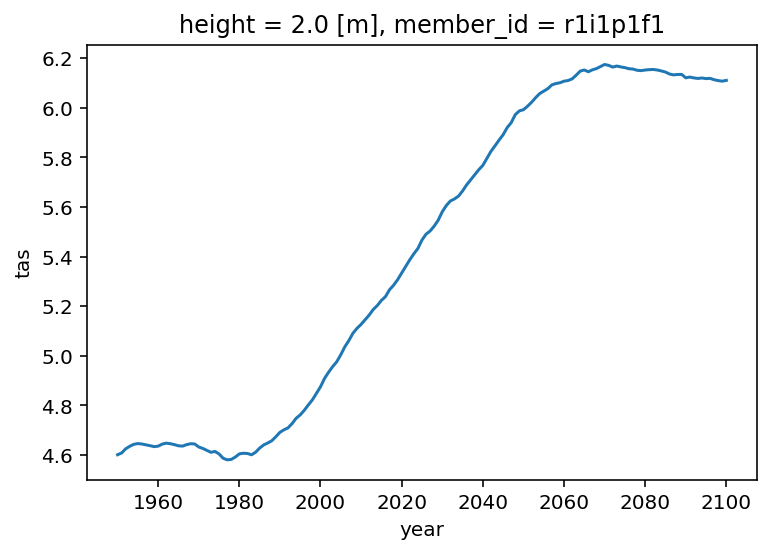

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
(mpi_esm_mean_.sel(year=slice(1950,2100))-273.5).plot()

So we could actually plot scenario time series data of MPI-ESM data without any preprocessing or merging simply from the original data. We don't even care where the data comes from, in which format it is stored or of how many files it consists on the filesystem. Actually, the data doesn't even have to be located on our filesystem but could also come from a cloud source.

But wait! That temperature seems low, doesn't it? That's because we forgot to [weight](http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html) the spatial mean with the area of the grid cell. And because grid cells at the pole are much smaller than at the equator, they have unsually large impact on the global mean. Let's quickly correct this:

In [17]:
weight = np.cos(np.deg2rad(mpi_esm.lat))
weight /= weight.mean()
mpi_esm_temporal_mean = mpi_esm.tas.groupby('time.year').mean(dim=('time')).compute().rolling(year=30).mean()
mpi_esm_weighted_mean = (mpi_esm_temporal_mean*weight).mean(dim=('lat', 'lon'))

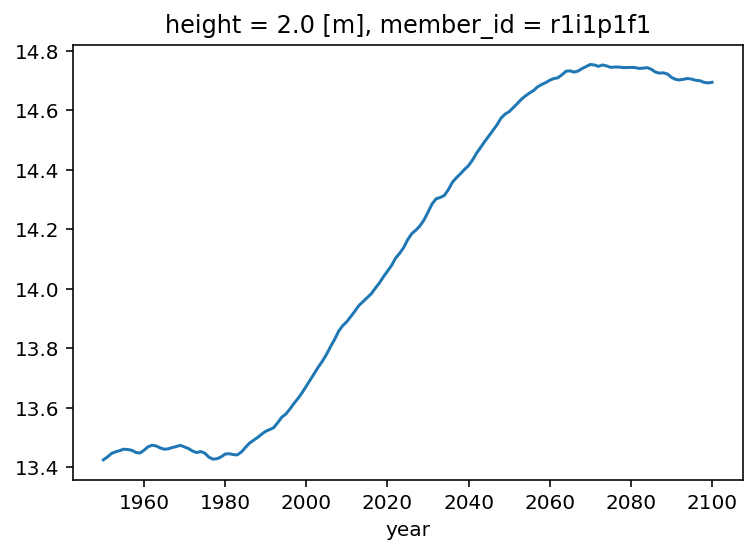

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
(mpi_esm_weighted_mean.sel(year=slice(1950,2100))-273.5).plot()

Better!

## Create an ensemble dataset

Ok, now that we know how to process single datasets, we can easily extend this to all datasets in our dataset dictionary. We create some helper functions for this (also for handling inconsistencies in the CMIP6 conventions):

In [19]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds
                 if (('bounds') in vname ) or ('bnds') in vname]
    return ds.drop(drop_vars)

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    """weighted spatial global mean"""
    ds = drop_all_bounds(ds)
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    return (ds*weight).mean(dim=('lon', 'lat'))


... and we also reorganize our data a little bit for easier access so that we can easily loop through all models and scenarios...

In [20]:
from collections import defaultdict
dsets_dict = defaultdict(dict)

from tqdm.autonotebook import tqdm

for key, ds in tqdm(dsets.items()):
    attrs = key.split('.')
    source_id = attrs[2]
    experiment_id = attrs[3]
    dsets_dict[source_id][experiment_id] = ds #.tas.groupby('time.year').mean() #.mean(dim=('lat', 'lon'))

  0%|          | 0/135 [00:00<?, ?it/s]

Unfortunately, there is always an issue with the timelines from the different models, e.g., CIESM uses a normal gregorian calendar...

In [21]:
dsets_dict.keys()

dict_keys(['CAS-ESM2-0', 'MRI-ESM2-0', 'EC-Earth3', 'MPI-ESM1-2-LR', 'IPSL-CM6A-LR', 'FGOALS-f3-L', 'NorESM2-MM', 'EC-Earth3-Veg-LR', 'MPI-ESM1-2-HR', 'CMCC-ESM2', 'CESM2-WACCM', 'FGOALS-g3', 'CanESM5', 'AWI-CM-1-1-MR', 'CAMS-CSM1-0', 'KACE-1-0-G', 'ACCESS-CM2', 'INM-CM5-0', 'GFDL-ESM4', 'TaiESM1', 'INM-CM4-8', 'MIROC6', 'NorESM2-LM', 'CMCC-CM2-SR5', 'IITM-ESM', 'BCC-CSM2-MR', 'EC-Earth3-Veg'])

while, e.g, `GFDL` uses a Calendar that ignores leap year, e.g.

This will get us in trouble, when we want to create an ensemble dataset because, by default, it's not clear how to align these calendars. But because we only have monthly means anyway, we can just ignore this and actually just hack in a common calendar for all datasets (we will set the data always to the 15th of the month). Furthermore we will compute the global weighted spatial mean for all models and scenarios. We also use a little trick where we will align all scenarios and the historical time series for each model into a single dataset where the scenario actually becomes not a key in the dictionary but a dataset coordinate! This will become clear in a minute:

In [22]:
from cftime import datetime as dt

expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                       coords={'experiment_id': expts})

dsets_aligned = {}

for k, v in tqdm(dsets_dict.items()):
    print(k)
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue

    for ds in expt_dsets:
        ds.coords['time'] = [dt(date.year, date.month, 15) for date in ds.time.values]
    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
    dsets_global_mean = [v[expt].pipe(global_mean)
                      for expt in expts]

    # 
    dsets_aligned[k] = xr.concat([ds.tas for ds in dsets_global_mean], join='outer',
                                 dim=expt_da).to_dataset()
    #dsets_aligned[k] = xr.concat([ds for ds in dsets_global_mean], join='outer',
    #                             dim=expt_da)

  0%|          | 0/27 [00:00<?, ?it/s]

CAS-ESM2-0
MRI-ESM2-0
EC-Earth3
MPI-ESM1-2-LR
IPSL-CM6A-LR
FGOALS-f3-L
NorESM2-MM
EC-Earth3-Veg-LR
MPI-ESM1-2-HR
CMCC-ESM2
CESM2-WACCM
FGOALS-g3
CanESM5
AWI-CM-1-1-MR
CAMS-CSM1-0
KACE-1-0-G
ACCESS-CM2
INM-CM5-0
GFDL-ESM4
TaiESM1
INM-CM4-8
MIROC6
NorESM2-LM
CMCC-CM2-SR5
IITM-ESM
BCC-CSM2-MR
EC-Earth3-Veg


Now, the resulting dictionary only has one key left for the source id (or the model) while the scenario is now a dataset coordinate. Let's have a look at `MPI-ESM1-2-LR` as an example to understand the advantage of this:

You can see that we, in fact, reduced the spatial dimensions (lat, lon) by the spatial mean and only have a time series of monthly data left. Furthemore, we aligned the historical and scenario datasets into one dataset with an `experiment_id` coordinate. This will make the further processing and plotting much easier because we can refer to the experiment like any other xarray coordinate ([labeled data](http://xarray.pydata.org/en/stable/why-xarray.html)). Note, that we didn't actually concatenate any files, etc. This dataset exists actually only virtually in the memory. Remember that we didn't actually trigger the computation yet, but we will do this now using dask:

**Note**: If you do this at home on your notebook, this computation might take some time, e.g., on my Macbook with 8GB of memory and 4 cores, it takes about 30 minutes to complete. However, it's still a reasonable amount of time considering the size of the ensemble i use. Morever, if i would do this, e.g., at DKRZ where i have direct access to the data, i would just take a couple of minutes. Don't forget to checkout out the dask dashboard to see the progress of the computation!

In [23]:
# compute spatial means for all models found in CMIP6
#with progress.ProgressBar():
import dask
%time dsets_aligned_ = dask.compute(dsets_aligned)[0]

CPU times: user 5min 23s, sys: 49.2 s, total: 6min 12s
Wall time: 28min 52s


That's it. Let's check the resulting keys in the dictionary:

In [24]:
dsets_aligned_.keys()

dict_keys(['CAS-ESM2-0', 'MRI-ESM2-0', 'EC-Earth3', 'MPI-ESM1-2-LR', 'IPSL-CM6A-LR', 'FGOALS-f3-L', 'NorESM2-MM', 'EC-Earth3-Veg-LR', 'MPI-ESM1-2-HR', 'CMCC-ESM2', 'CESM2-WACCM', 'FGOALS-g3', 'CanESM5', 'AWI-CM-1-1-MR', 'CAMS-CSM1-0', 'KACE-1-0-G', 'ACCESS-CM2', 'INM-CM5-0', 'GFDL-ESM4', 'TaiESM1', 'INM-CM4-8', 'MIROC6', 'NorESM2-LM', 'CMCC-CM2-SR5', 'IITM-ESM', 'BCC-CSM2-MR', 'EC-Earth3-Veg'])

Now, we can make one furter last step in defining our ensemble data. We will do the same trick again and also make the model id a coordinate by concatenating all datasets. Since we only have time series data (without any spatial dimension) and because we fixed the different calendars, we can do this very easily:

In [25]:
# define the model coordinate
models = list(dsets_aligned_.keys())
model_da = xr.DataArray(models, dims='model', name='model',
                         coords={'model': models})

# concatenate all datasets from the dictionary
ensemble_ds = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_.values()],
                    dim=model_da)
ensemble_ds

<xarray.Dataset>
Dimensions:        (model: 27, time: 5412, experiment_id: 5, member_id: 1)
Coordinates:
  * model          (model) <U16 'CAS-ESM2-0' 'MRI-ESM2-0' ... 'EC-Earth3-Veg'
  * time           (time) object 1850-01-15 00:00:00 ... 2300-12-15 00:00:00
  * experiment_id  (experiment_id) <U10 'historical' 'ssp126' ... 'ssp585'
  * member_id      (member_id) <U8 'r1i1p1f1'
Data variables:
    tas            (model, experiment_id, member_id, time) float64 285.1 ... nan

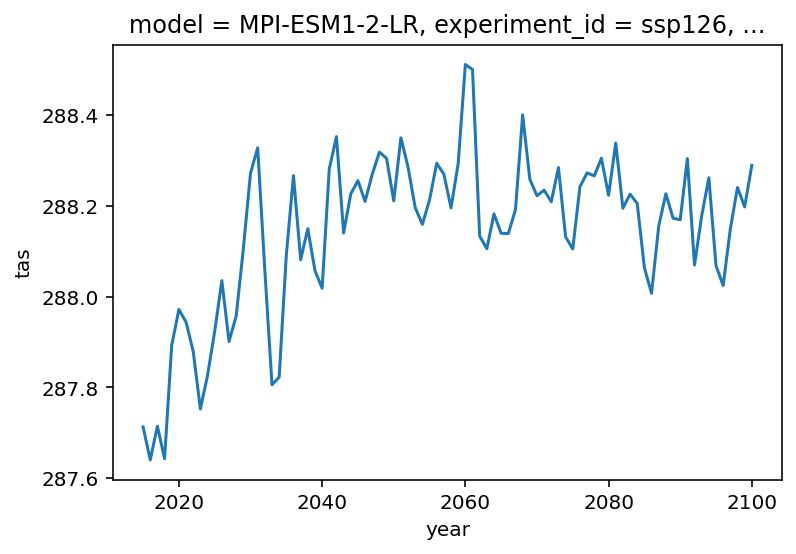

In [26]:
ensemble_ds.tas.sel(model='MPI-ESM1-2-LR', experiment_id='ssp126').groupby('time.year').mean().plot()

For the next steps in plotting, we will use a baseline period for comparison of future scenarios with historical data.

In [27]:
# use NASA GISS baseline for comparison with observations
baseline_period = slice('1951','1980')
reference = ensemble_ds.tas.sel(time=baseline_period, experiment_id='historical').mean(dim='time')

## Plotting

The virtual dataset will make the rest of our analysis really easy and straight forward. For example, let's plot annual means for **all** datasets:

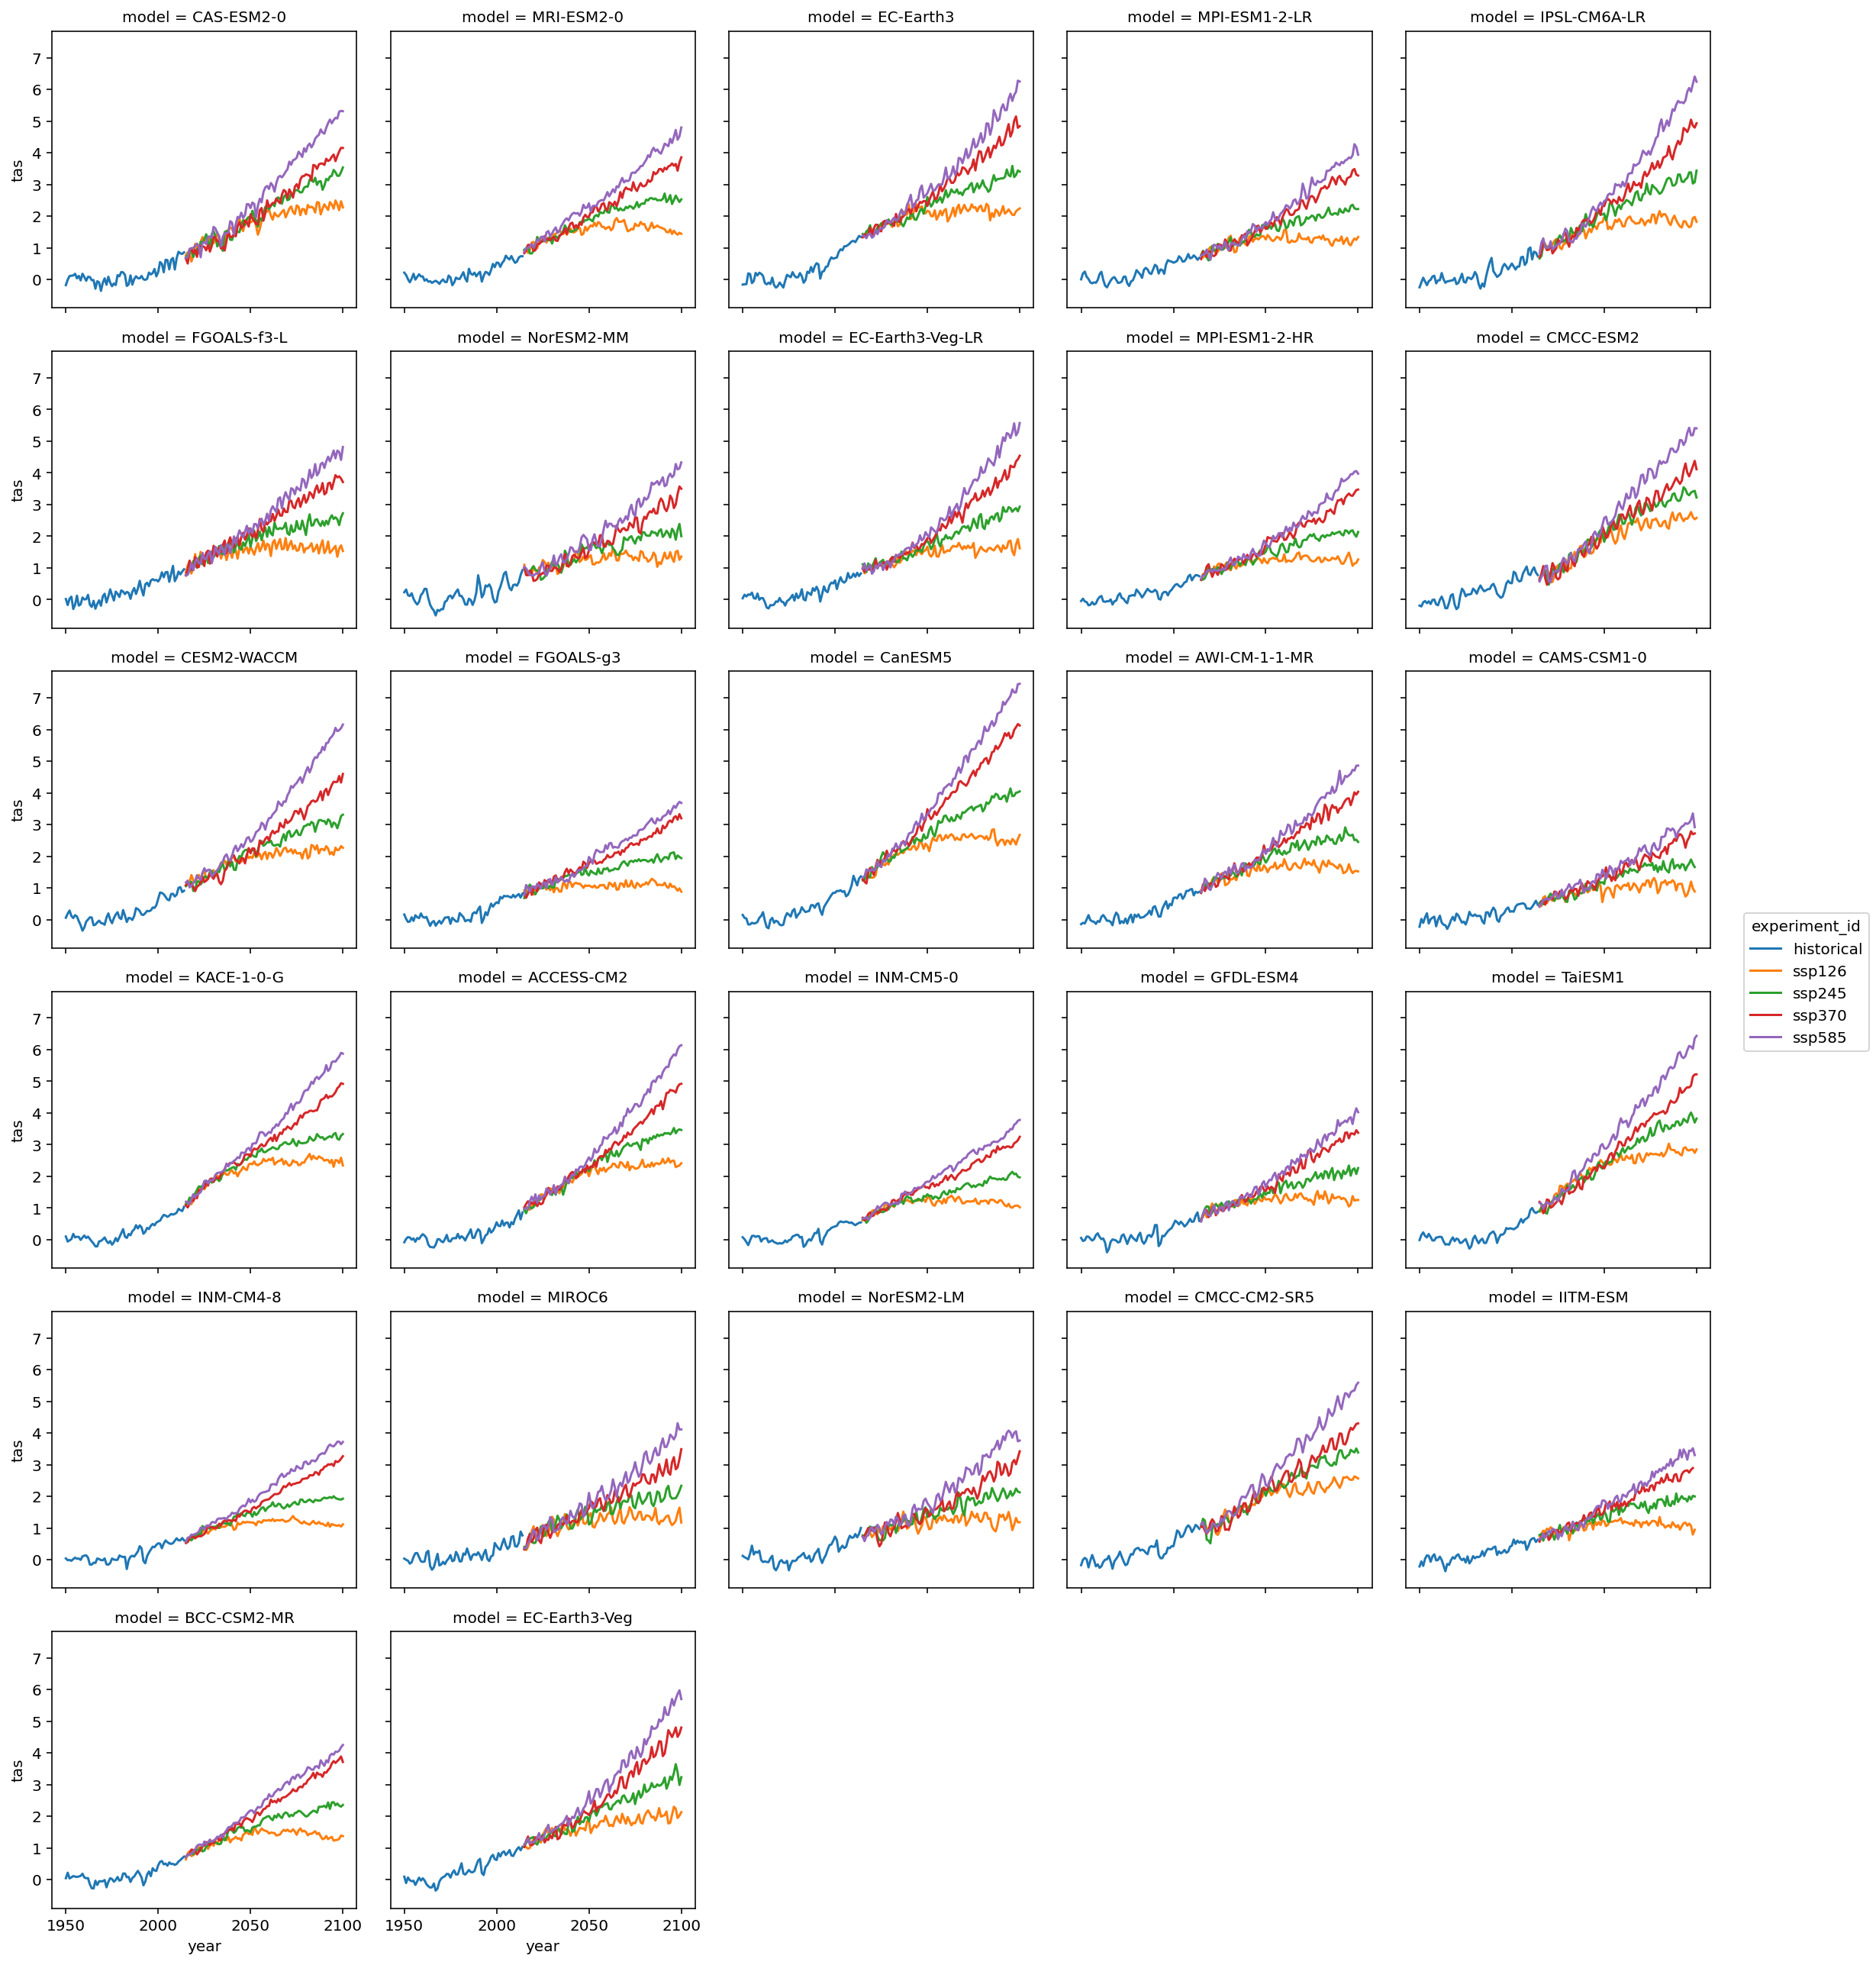

In [28]:
# compute the annual mean
annual_mean = (ensemble_ds-reference).groupby('time.year').mean()
# create a line plot for each model id!
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#annual_mean.drop('member_id')
(annual_mean.tas.sel(year=slice(1950,2100))).plot(col='model', x='year', hue='experiment_id', col_wrap=5)

### Fill scenario timelines with historical data

If we want to compute a 30 year running mean (typical for climate timescales), we need to fill the scenario timelines with historical values (right now, they have `nan`s because the scenario experiments simply have no values for those dates earlier than 2015) so we dont' have gaps in the plot. We have to provide those values because the [running mean](https://en.wikipedia.org/wiki/Moving_average) calculation requires a certain *rolling window size* to compute the values. There are several ways of [indexing, selectiong and assigning data in xarray](http://xarray.pydata.org/en/stable/indexing.html) that is similar to the pandas syntax. First, let's define the time slices:

In [29]:
# we fill the 30 years before the end of the historical part...
# this would need to be shifted if you want center=True
#hist_slice = slice(pd.Timestamp('2000-01-15'),pd.Timestamp('2014-12-15'))
hist_slice = slice('1985','2014')

The `.sel` syntax does not allow for assignment but will create a copy of the selected data. We have to use the `.loc` syntax to [assign data](https://github.com/pydata/xarray/issues/1519) to an existing dataset. 

In [30]:
for exp in ensemble_ds.experiment_id:
     ensemble_ds.tas.loc[{'time':hist_slice, 'experiment_id': [exp.values]}] = \
        ensemble_ds.tas.sel(time=hist_slice, experiment_id=['historical']).values

Ok, we are done. We have now our complete ensemble data in one virtual four dimensional dataset (`model`, `experiment_id`, `member_id`, `time`).  

We have to explicitly call the `.compute()` function of dask because the rollinge operation ([#3040](https://github.com/pydata/xarray/pull/3040)) does not allow chunked data yet. 

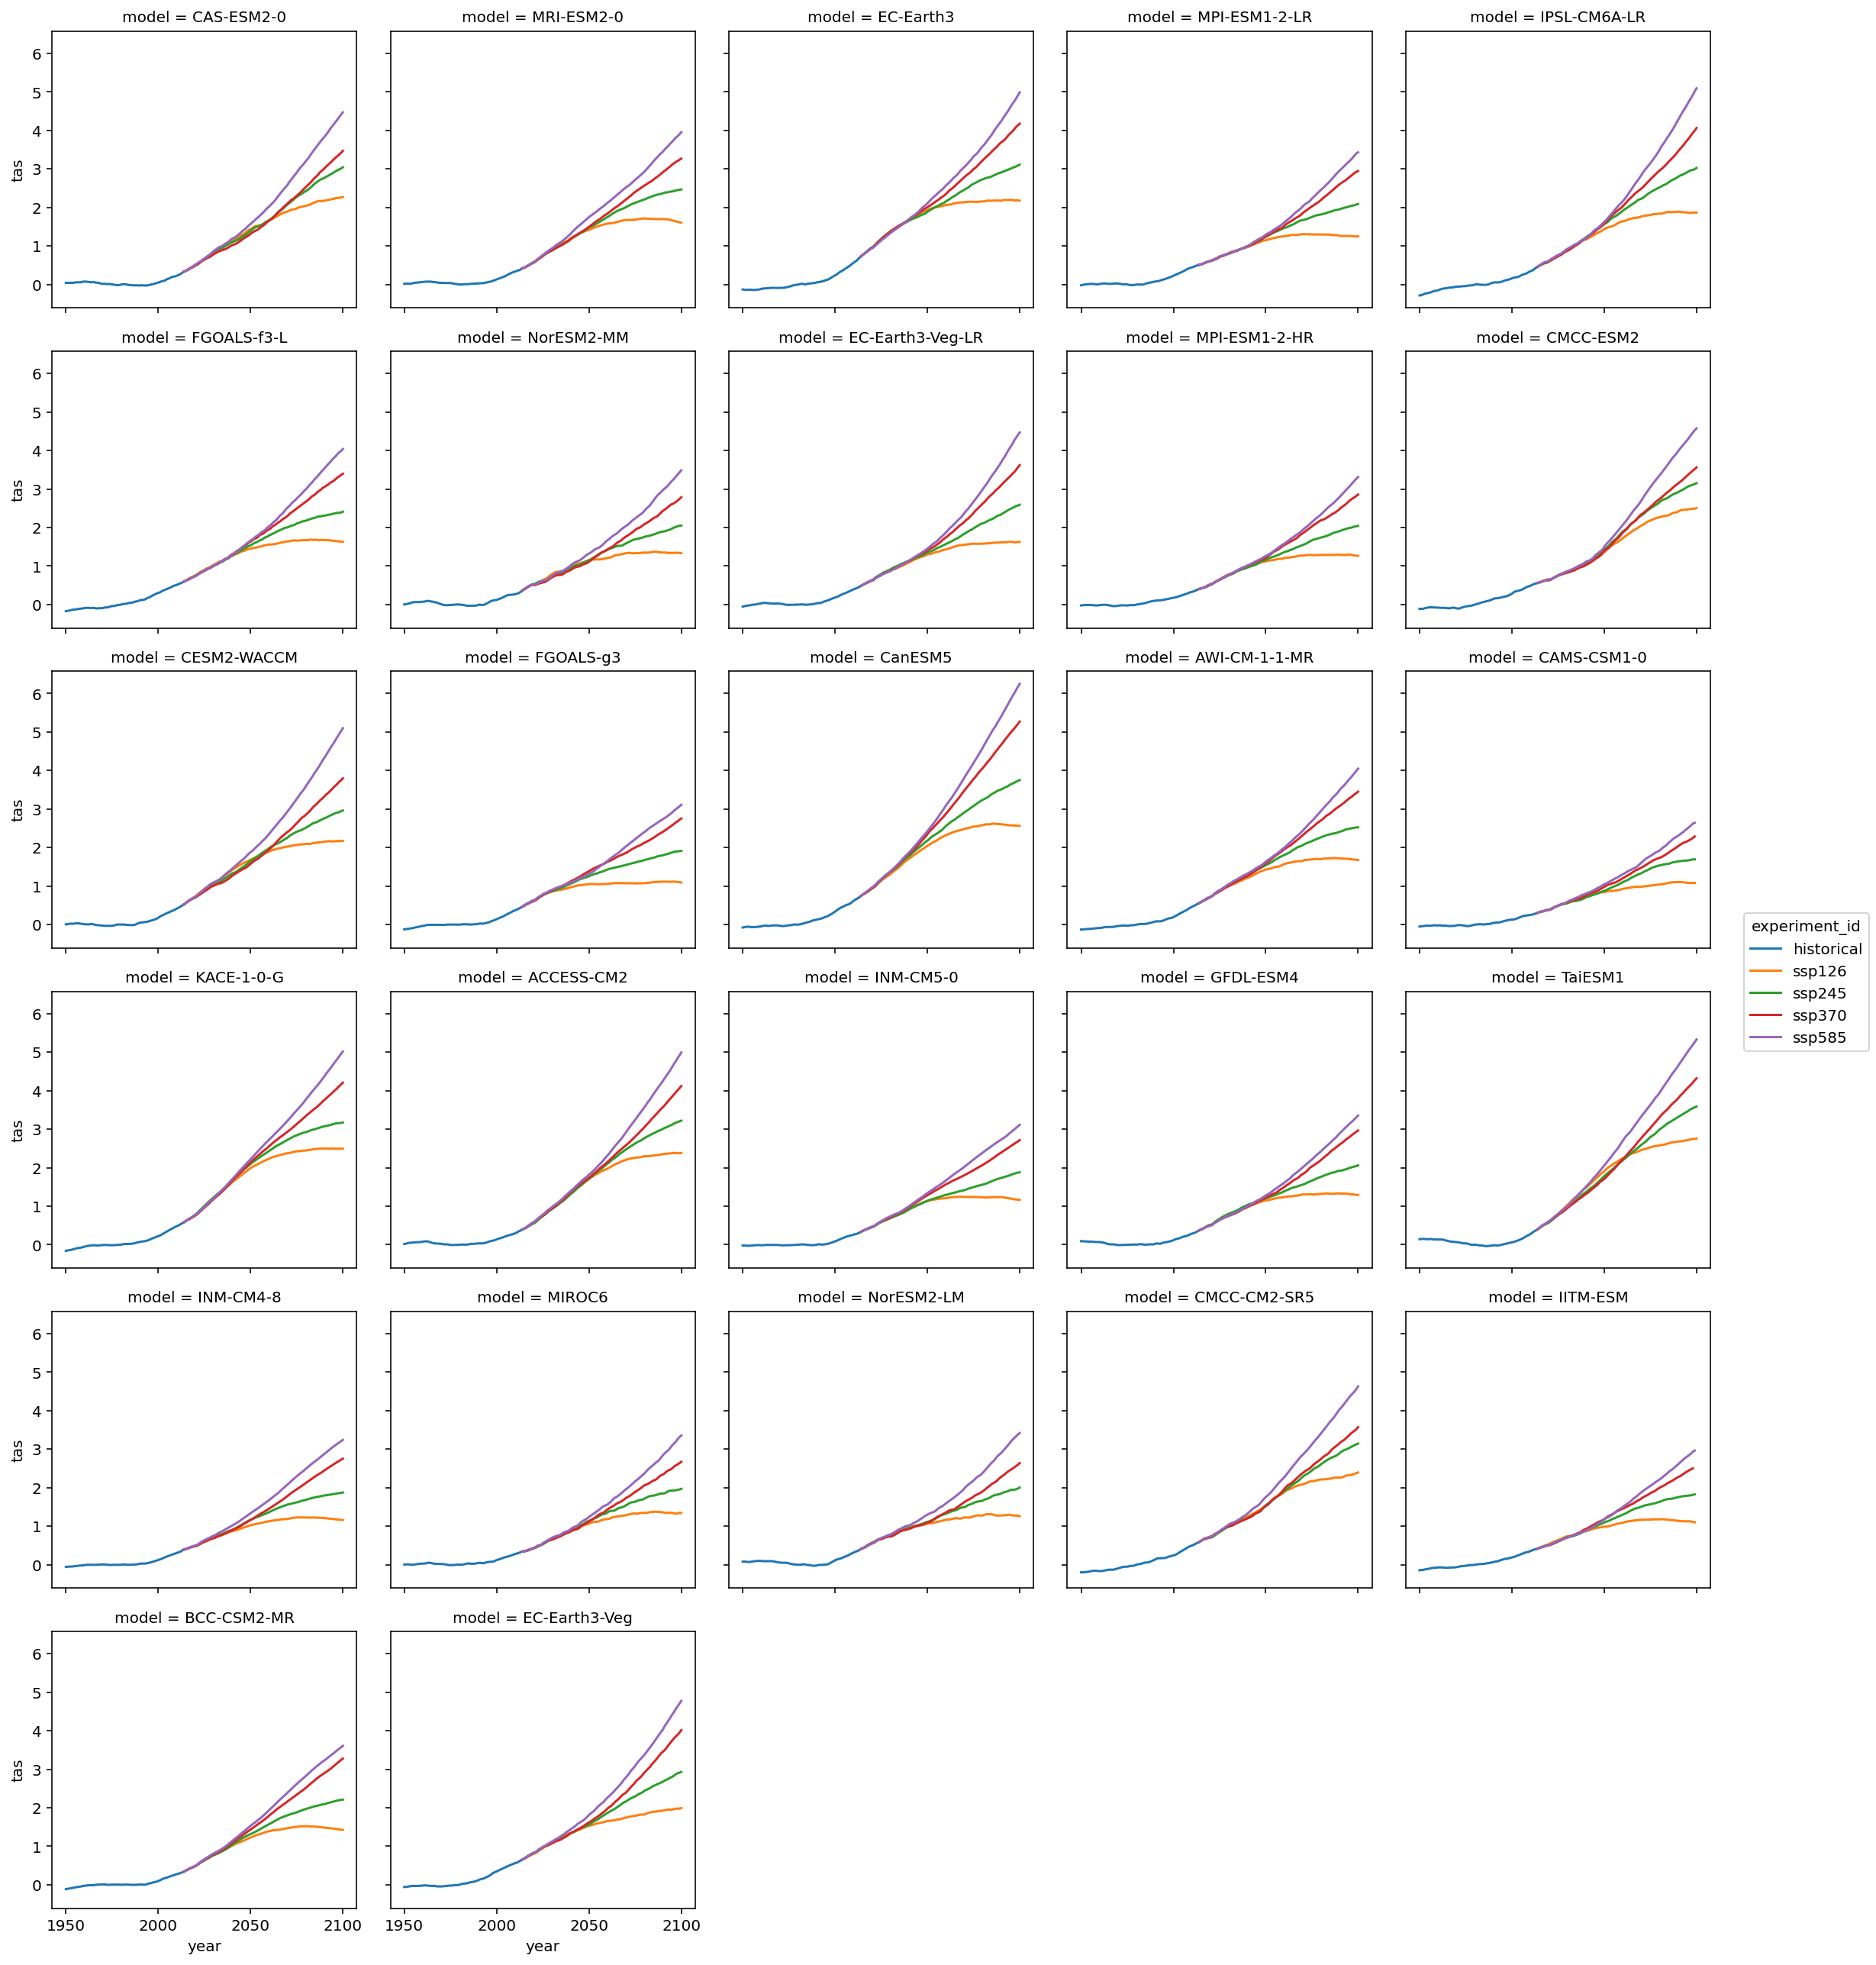

In [31]:
# compute the rolling annual mean
rolling_mean = (ensemble_ds-reference).groupby('time.year').mean().compute().rolling(year=30).mean()
# create a line plot for each model id!
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#annual_mean.drop('member_id')
(rolling_mean.tas.sel(year=slice(1950,2100))).plot(col='model', x='year', hue='experiment_id', col_wrap=5)

You can see that we now can use the additional coordinates to easily plot the data in different formats.

## Bonus step: get into pandas for more plotting and data wrangling...

Because we have reduced our data to a number of time series, it's ideal to use pandas for further analysis. xarray has a nice feature for this which will convert your dataset or dataarray into a pandas dataframe. Pandas also works well with [seaborn](https://seaborn.pydata.org/) and other visualization and statistics libraries!

In [32]:
import seaborn as sns

In [33]:
df_annual = annual_mean.sel(year=slice(1950, 2100)).to_dataframe().reset_index()
df_annual.head()

,model,experiment_id,member_id,year,tas
0,CAS-ESM2-0,historical,r1i1p1f1,1950,-0.175955
1,CAS-ESM2-0,historical,r1i1p1f1,1951,-0.003697
2,CAS-ESM2-0,historical,r1i1p1f1,1952,0.112204
3,CAS-ESM2-0,historical,r1i1p1f1,1953,0.122432
4,CAS-ESM2-0,historical,r1i1p1f1,1954,0.129607


In [34]:
df_running = rolling_mean.sel(year=slice(1950, 2100)).to_dataframe().reset_index()
df_running.head()

,model,experiment_id,member_id,year,tas
0,CAS-ESM2-0,historical,r1i1p1f1,1950,0.043971
1,CAS-ESM2-0,historical,r1i1p1f1,1951,0.044715
2,CAS-ESM2-0,historical,r1i1p1f1,1952,0.043647
3,CAS-ESM2-0,historical,r1i1p1f1,1953,0.044090
4,CAS-ESM2-0,historical,r1i1p1f1,1954,0.043747


Now, we can use, e.g., seaborn to make a nice ensemble plot for all models and scenarios:

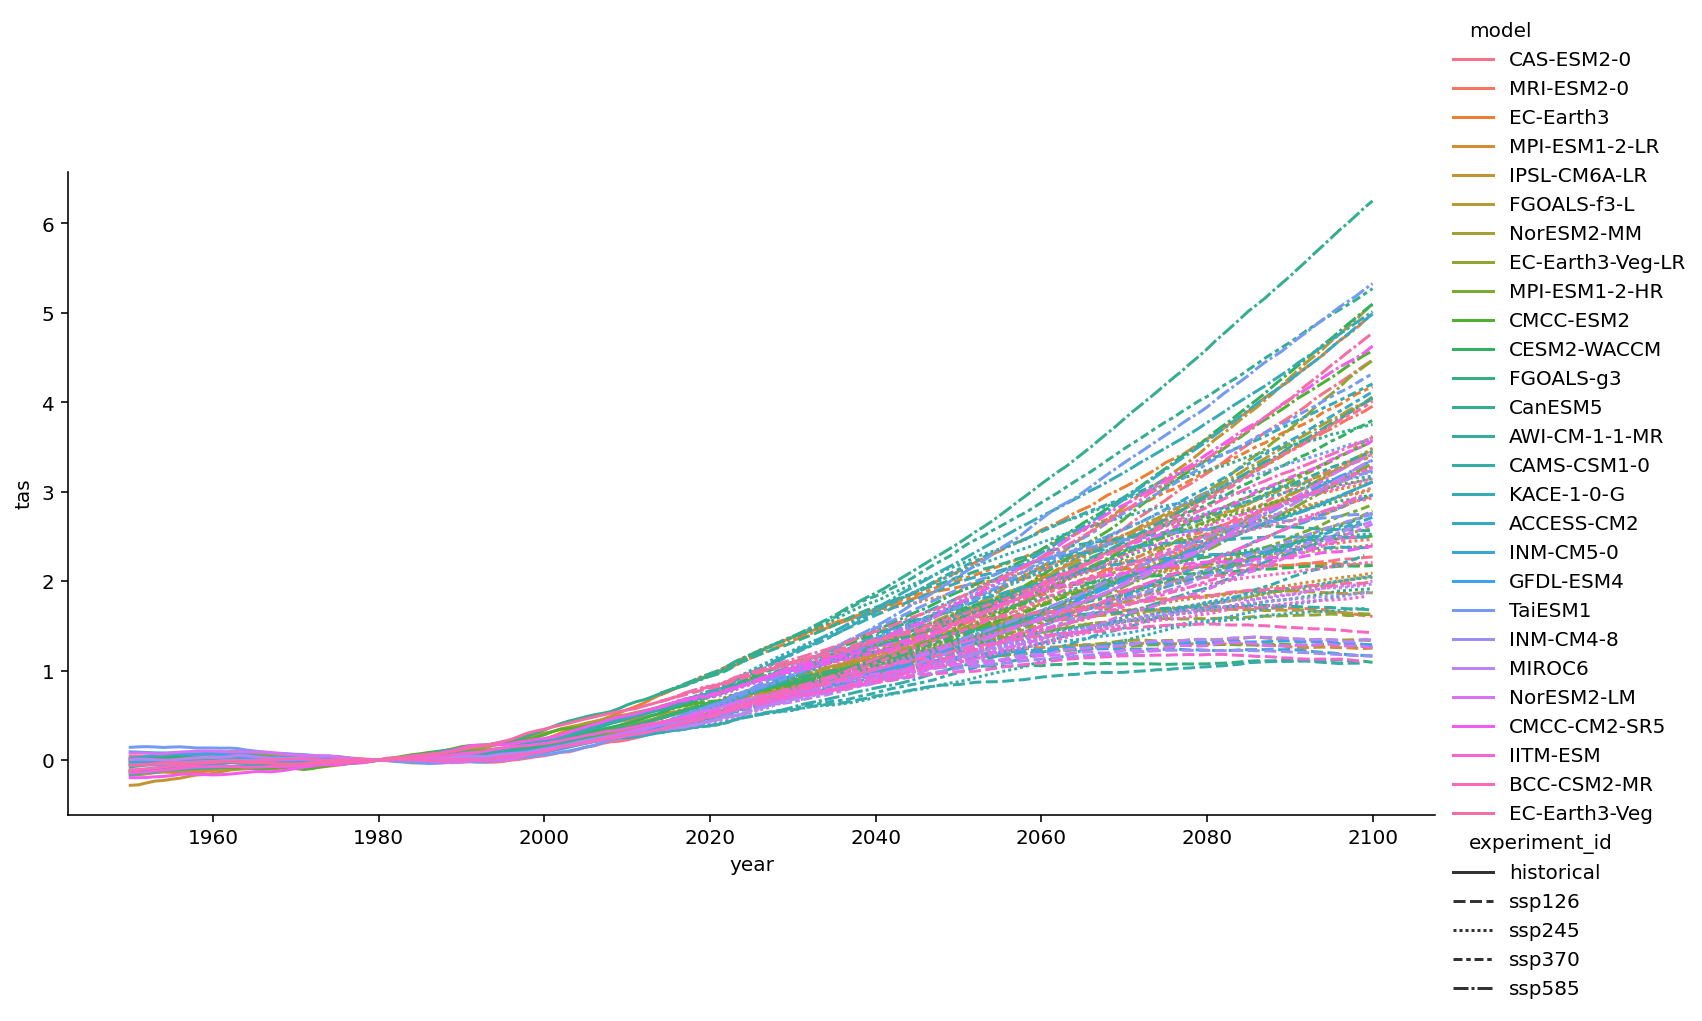

In [35]:
sns.relplot(data=df_running,
            x="year", y="tas", hue='model',
            kind="line", style='experiment_id', aspect=2);

Such a plot doesn't seem to be very useful because the dataset has too many dimensions, e.g., you would want to distinguish between scenario and model in one plot using colors and linestyles. We should use more statistics to explore that dataset, e.g., we will plot the multi-model mean with a confidence interval. 

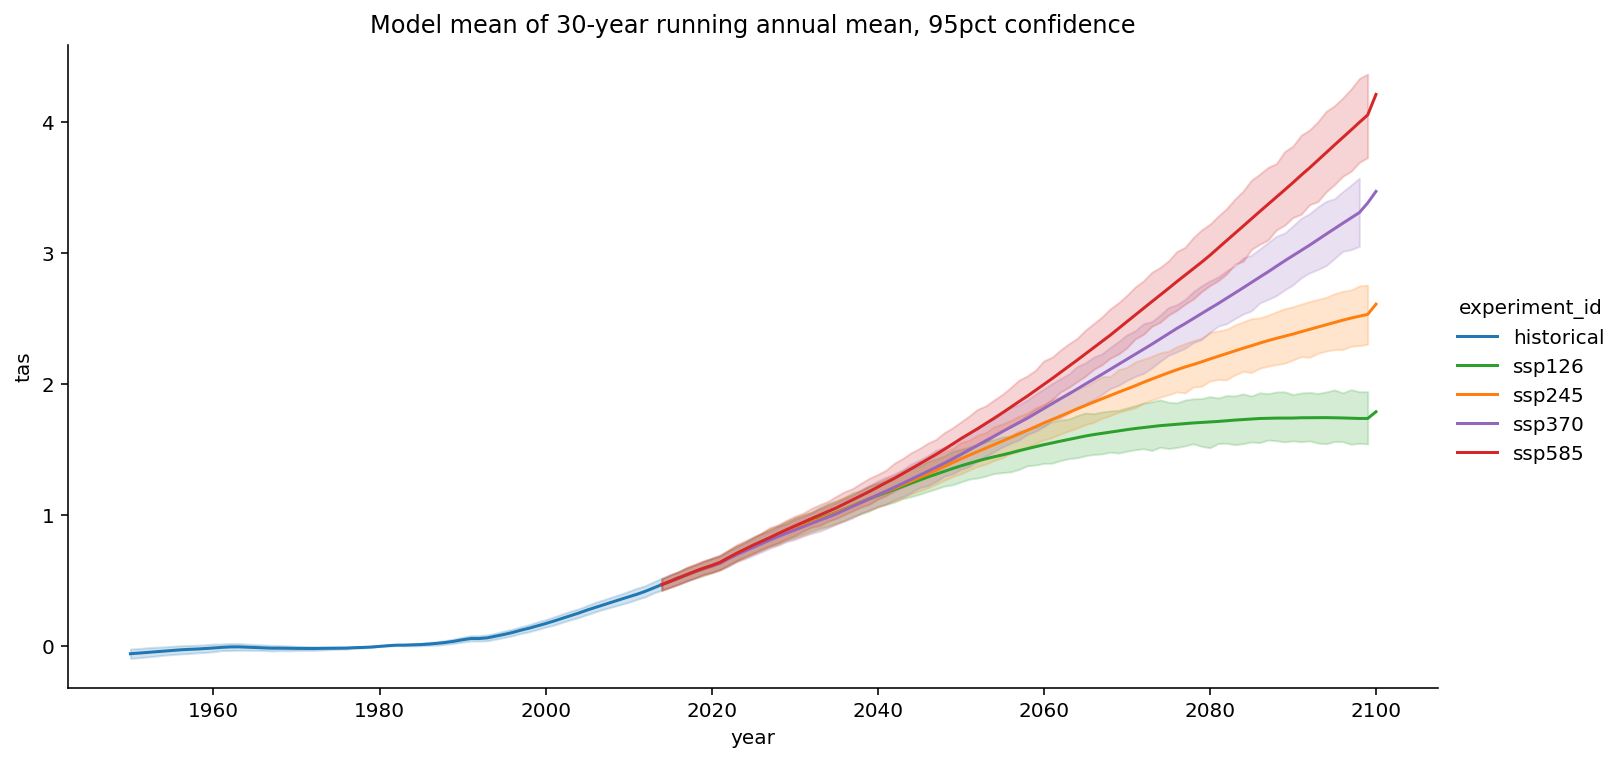

In [36]:
palette ={"historical": "C0", "ssp126": "C2", "ssp245": "C1", "ssp370":"C4", "ssp585": "C3"}
g = sns.relplot(data=df_running,
            x="year", y="tas", hue="experiment_id",
            kind="line", ci=95, aspect=2, palette=palette);
g.set(title="Model mean of 30-year running annual mean, 95pct confidence")

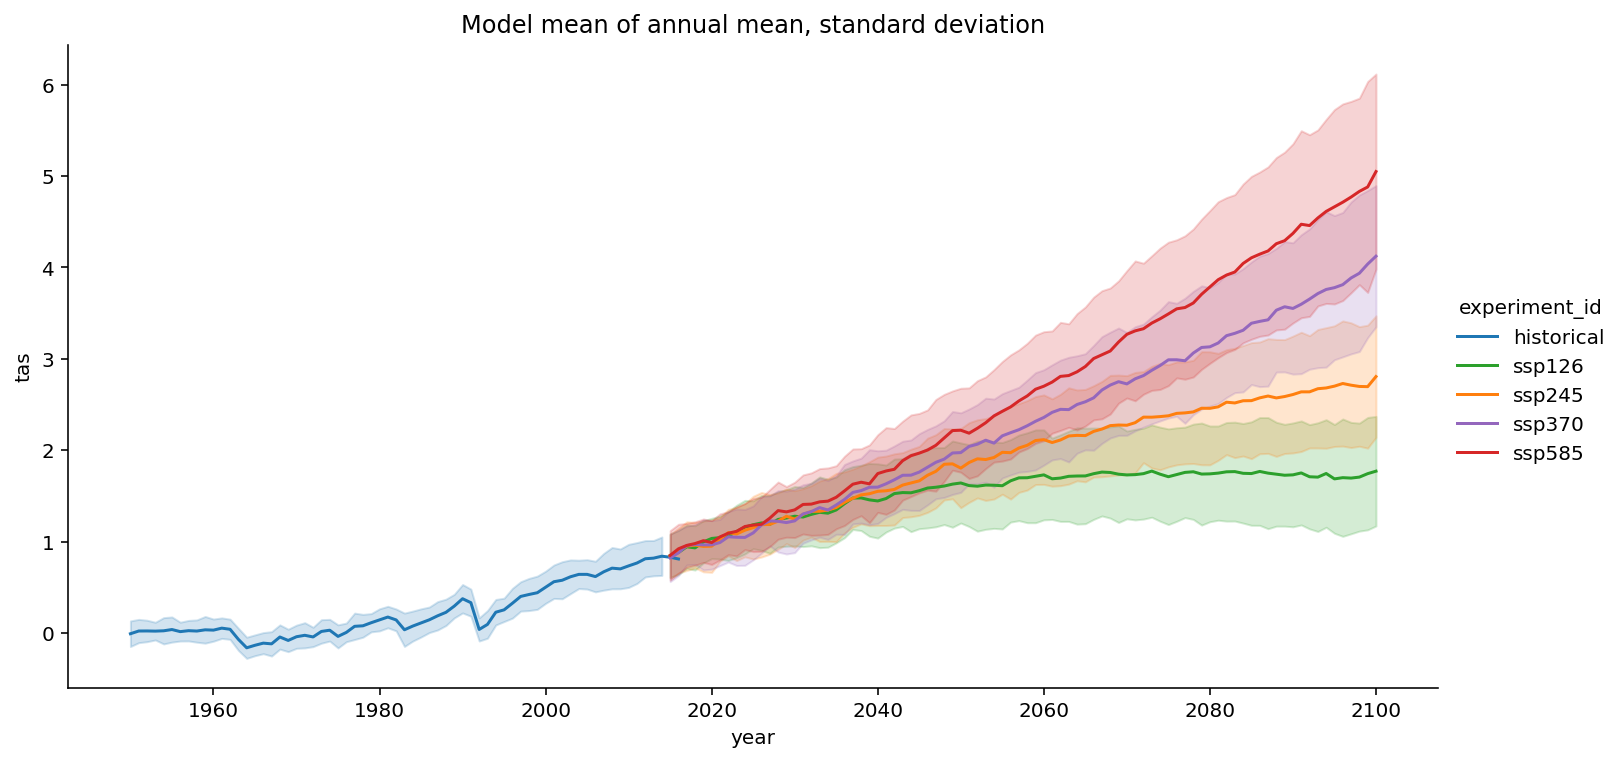

In [37]:
palette ={"historical": "C0", "ssp126": "C2", "ssp245": "C1", "ssp370": "C4", "ssp585": "C3"}
g = sns.relplot(data=df_annual,
            x="year", y="tas", hue="experiment_id",
            kind="line", ci='sd', aspect=2, palette=palette);
g.set(title="Model mean of annual mean, standard deviation")

### Comparison with observations

We want to compare the model data to actual observations! We will use data from [Nasa GISS Surface Temperature Analysis](https://data.giss.nasa.gov/gistemp/). Let's read the data directly from the url:

In [43]:
observations_csv = "https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv"
df_obs = pd.read_csv(observations_csv, header=1, index_col='Year')
df_obs.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
Year,,,,,,,,,,,,,,,,,,
1880,-0.17,-0.24,-0.08,-0.15,-0.09,-0.20,-0.17,-0.09,-0.14,-0.23,-0.21,-0.17,-0.16,***,***,-0.11,-0.16,-0.19
1881,-0.19,-0.13,0.04,0.06,0.07,-0.18,0.01,-0.03,-0.15,-0.21,-0.18,-0.06,-0.08,-.09,-.16,0.06,-0.07,-0.18
1882,0.17,0.14,0.05,-0.15,-0.13,-0.22,-0.16,-0.07,-0.15,-0.23,-0.16,-0.36,-0.11,-.08,.08,-0.08,-0.15,-0.18
1883,-0.29,-0.36,-0.12,-0.18,-0.17,-0.06,-0.07,-0.13,-0.22,-0.11,-0.24,-0.11,-0.17,-.19,-.34,-0.16,-0.09,-0.19
1884,-0.13,-0.08,-0.36,-0.40,-0.33,-0.34,-0.32,-0.27,-0.27,-0.25,-0.33,-0.30,-0.28,-.26,-.10,-0.36,-0.31,-0.28


We will align the observational data with our model dataset, this requires some restructuring of the data, e.g., we have to make monthly columns into pandas datetime objects...

,time,tas
0,1880-01-15,-0.17
1,1880-02-15,-0.24
2,1880-03-15,-0.08
3,1880-04-15,-0.15
4,1880-05-15,-0.09


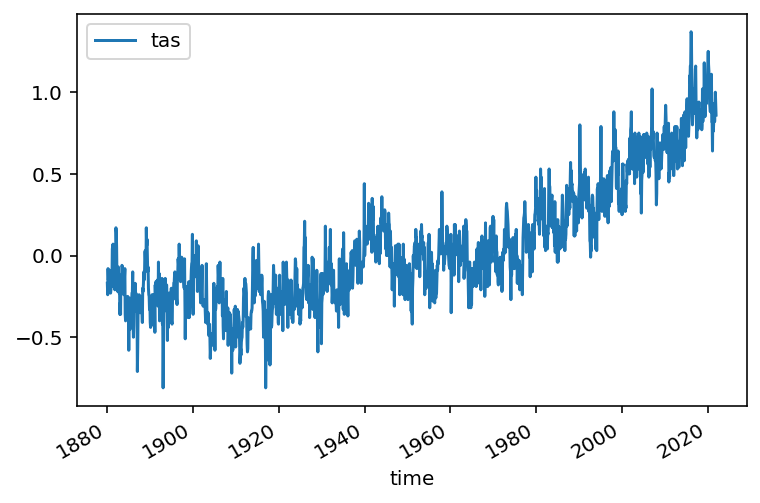

In [45]:
import calendar as cal
import datetime as dt

clean_tas = {}

for year, row in df_obs.iterrows():
    for month in range(1,13):
        tas = row[cal.month_abbr[month]]
        date = dt.date(year, month, 15)
        try:
            clean_tas[date] = np.float64(tas)
        except:
            clean_tas[date] = np.nan
            
df_obs_ = pd.DataFrame.from_dict(clean_tas, orient='index').reset_index().rename(columns={'index':'time', 0:'tas'})
df_obs_['time'] = pd.to_datetime(df_obs_.time)
df_obs_.plot(x='time', y='tas')
df_obs_.head()

Now, the data is in alignement with our model data and we can concaetnate both tables using the time as index.

In [46]:
df_obs_annual = df_obs_.groupby(df_obs_.time.dt.year).mean()
df_obs_annual[['model', 'experiment_id']] =  'NASA GISS'
df_obs_annual.head()

,tas,model,experiment_id
time,,,
1880,-0.161667,NASA GISS,NASA GISS
1881,-0.079167,NASA GISS,NASA GISS
1882,-0.105833,NASA GISS,NASA GISS
1883,-0.171667,NASA GISS,NASA GISS
1884,-0.281667,NASA GISS,NASA GISS


In [47]:
df_annual_with_obs = pd.concat([df_obs_annual, df_annual.set_index('year')])
df_annual_with_obs = df_annual_with_obs.reset_index().rename(columns={'index':'year'})

Now, we can repeat the plot easily including the observational dataset.

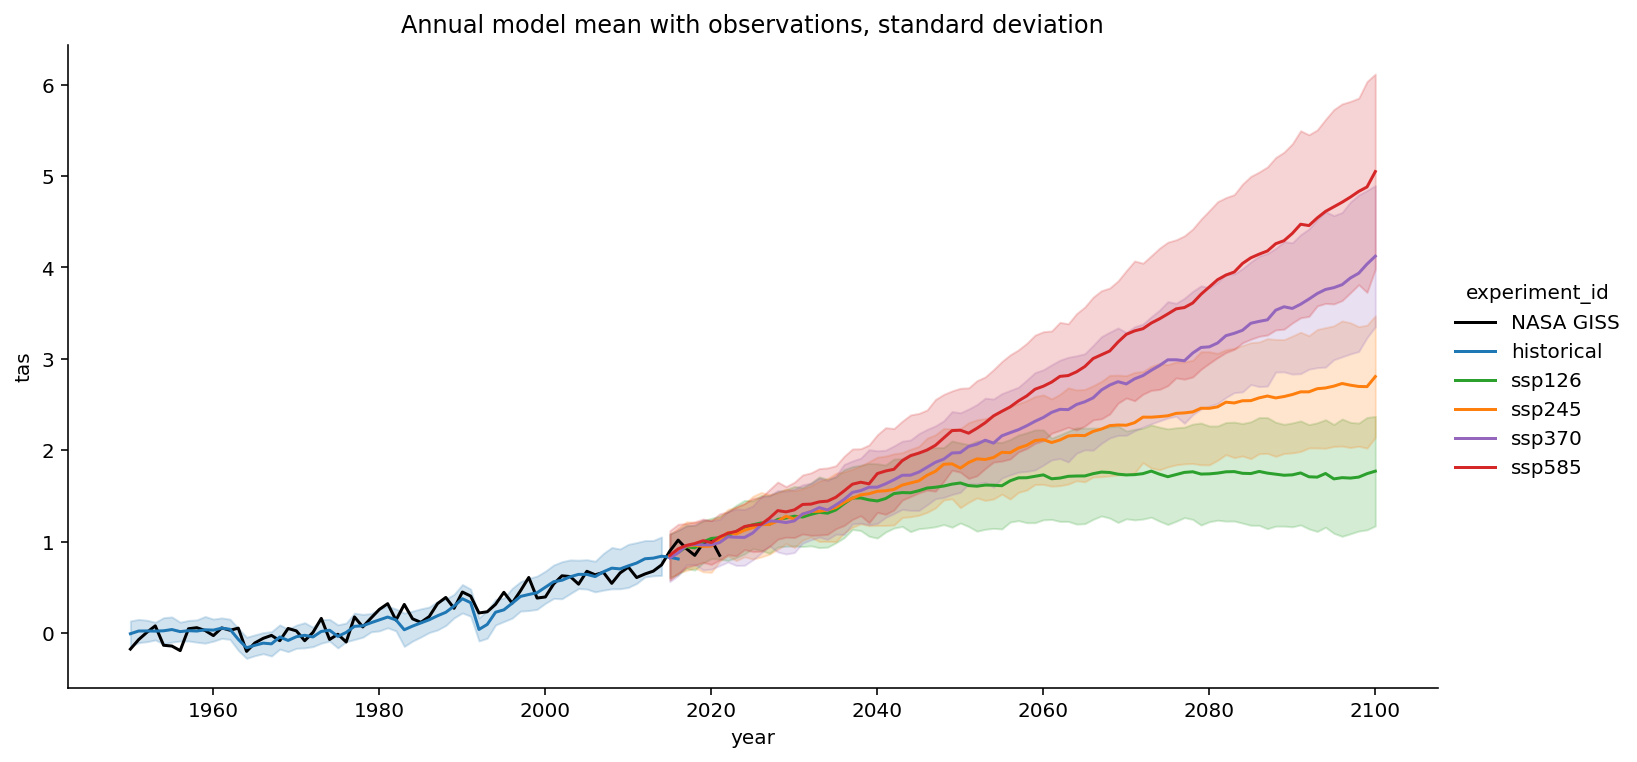

In [48]:
palette ={"historical": "C0", "ssp126": "C2", "ssp245": "C1", "ssp370": "C4", "ssp585": "C3", "NASA GISS": "k"}
g = sns.relplot(data=df_annual_with_obs.loc[df_annual_with_obs.year >= 1950],
            x='year', y="tas", hue="experiment_id",
            kind="line", ci='sd', aspect=2, palette=palette);
g.set(title="Annual model mean with observations, standard deviation")

### some more plotting capabilities of pandas and seaborn

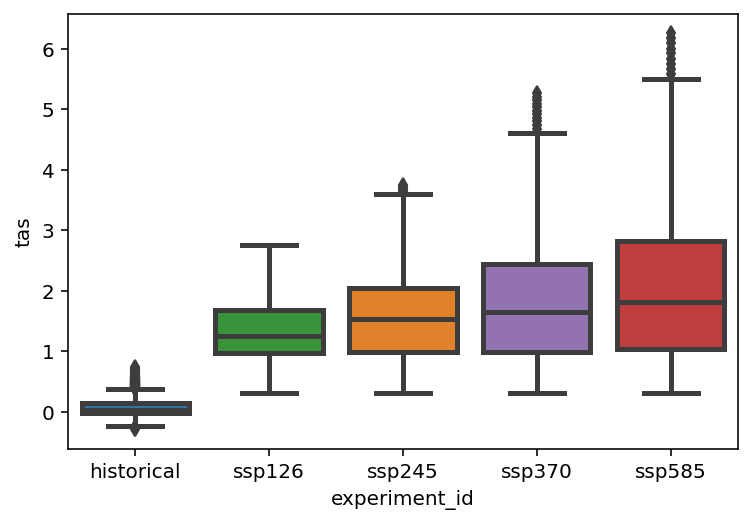

In [49]:
ax = sns.boxplot(x="experiment_id", y="tas",
                 data=df_running, linewidth=2.5, palette=palette)

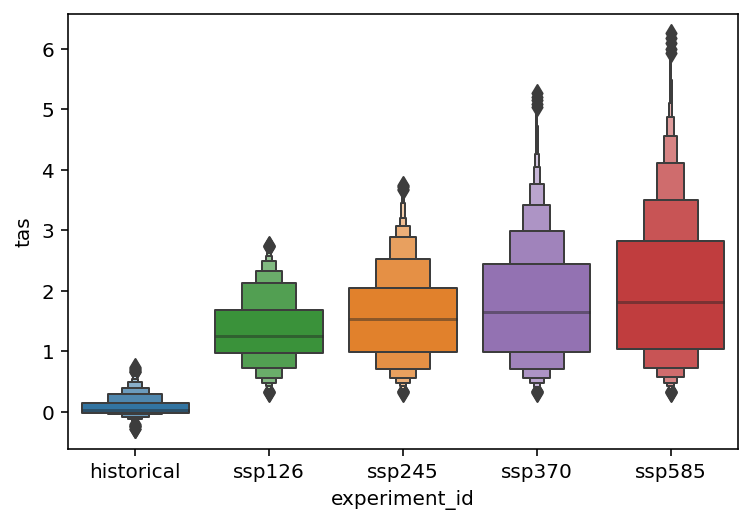

In [50]:
# https://vita.had.co.nz/papers/letter-value-plot.html
ax = sns.boxenplot(x="experiment_id", y="tas",
                 data=df_running, linewidth=2.5, palette=palette)

In [51]:
df_running.to_csv('cmip6_running_global_mean.csv')
df_annual_with_obs.to_csv('cmip6_annual_global_mean.csv')